In [2]:
import pandas as pd
from pandas import Series, DataFrame
import datetime 
from datetime import datetime

In [10]:
disney_p = pd.read_csv('/Users/chereowang27/NYCDSA/Python_Intro/Python_Intro_Project/data/disney_plus_shows.csv', header=0)
netflix = pd.read_csv('/Users/chereowang27/NYCDSA/Python_Intro/Python_Intro_Project/data/netflix_list.csv', header=0)

#convert added at date from str to datetime, make variable for the year, and month-year
disney_p['added_at'] = disney_p["added_at"].apply(lambda s: datetime.strptime(s, "%d-%b-%y"))
disney_p['added_atyear'] = disney_p['added_at'].apply(lambda s: s.strftime('%y'))
disney_p['added_atmonth_year'] = disney_p['added_at'].apply(lambda s: s.strftime('%b-%y'))
disney_p['added_atmonth_year_new'] = pd.to_datetime(disney_p['added_atmonth_year'], format = '%b-%y')

#convert runtime & imdb_rating to numeric
disney_p['runtime'] = disney_p['runtime'].str.split(' ')
disney_p['runtime'] = [pd.to_numeric(val[0:1]) if hasattr(val, '__iter__') else None for val in disney_p["runtime"]]

disney_p['data'] = 'Disney_plus'
netflix['data'] = 'Netflix'
#disney_p['added_atmonth_year'] =  disney_p['added_atyear'].apply(lambda s: datetime.date(s.month, s.year))

hyphen = disney_p['year'].str.split(pat = '-', expand = True ).loc[30,0][4]
df_year = disney_p['year'].str.split(pat = hyphen, expand = True ) \
            .rename(columns = {0:'yearStart', 1: 'yearEnd'})
       

disney_p = pd.concat([disney_p,df_year], axis = 1)

#count the number of movies in each genre
d_movie = disney_p[(disney_p['type']=='movie')]
# d_tv = disney_p[(disney_p['type'] != 'movie') & disney_p['type']!= ' ']
# n_tv = netflix[netflix['type'] != 'movie']

In [13]:
df_year


,yearStart,yearEnd
0,1999,None
1,2018,
2,1996,None
3,2002,None
4,2000,None
...,...,...
987,2014,None
988,1999,None
989,2001,None
990,2004,None


In [14]:
# this checks where the titles from disney plus and netflix titles overlap
# 19 titles in both networks
disney_nf = pd.merge(disney_p[['imdb_id','imdb_rating','title']],
          netflix[['imdb_id','rating','title']],
                  on='imdb_id', 
                  how = 'inner', 
         suffixes= ('_disney','_nf')
        )
disney_nf.head()


,imdb_id,imdb_rating,title_disney,rating,title_nf
0,tt0115433,5.7,101 Dalmatians,5.7,101 Dalmatians
1,tt3606752,6.7,Cars 3,6.7,Cars 3
2,tt0756522,6.2,Little Einsteins,6.2,Little Einsteins
3,tt2277860,7.3,Finding Dory,7.3,Finding Dory
4,tt2294629,7.5,Frozen,7.4,Frozen


In [15]:
gr_d = set(disney_p['genre'].str.cat(sep = ', ').split(', '))
gr_n = set(netflix['genres'].str.cat(sep = ',').split(','))

print(gr_d - gr_n)
print(gr_n - gr_d)



set()
{'\\N', 'Film-Noir'}


In [16]:
#now output all genres in disney and in netflix; find unique genres 
gr_d_m = set(d_movie['genre'].str.cat(sep = ', ').split(', '))
gr_n_m = set(netflix[netflix['type']=='movie']['genres'].str.cat(sep = ',').split(','))
print(gr_d_m - gr_n_m)
print(gr_n_m - gr_d_m)


{'Reality-TV'}
{'\\N', 'Film-Noir'}


In [17]:
# pd.to_numeric(''.join(d_movie['imdb_votes'][0].split(',')))
#d_movie['imdb_votes'].apply(lambda x: pd.to_numeric(''.join(x.split(','))))

d_movie=d_movie.loc[~d_movie["imdb_votes"].isnull()]
d_movie['imdb_votes']=d_movie['imdb_votes'].apply(lambda x: pd.to_numeric(''.join(x.split(','))))

In [18]:
#compare imdb scores of movies in disney & netflix 
d_movie = d_movie.rename(columns = {'imdb_rating': 'rating'})
nf_movie = netflix[(netflix['type']=='movie')|(netflix['type']=='tvMovie')&(netflix['startYear'] < 2020)] \
           .rename(columns={'genres':'genre','startYear': 'added_atyear','numVotes':'imdb_votes','orign_country':'country'})
nf_movie['imdb_votes'] = pd.to_numeric(nf_movie['imdb_votes'])
allMovie = pd.concat([d_movie[['imdb_id','country','rating', 'imdb_votes','genre', 'added_atyear','data']],nf_movie[['imdb_id','country','rating','imdb_votes','genre','added_atyear','data']]])
allMovie


,imdb_id,country,rating,imdb_votes,genre,added_atyear,data
0,tt0147800,USA,7.3,283945.0,"Comedy, Drama, Romance",19,Disney_plus
2,tt0115433,"USA, UK",5.7,97785.0,"Adventure, Comedy, Crime, Family",19,Disney_plus
3,tt0324941,USA,5.8,7434.0,"Animation, Adventure, Comedy, Family, Musical",19,Disney_plus
4,tt0211181,"USA, UK",4.9,33444.0,"Adventure, Comedy, Family",19,Disney_plus
5,tt1846442,USA,6.3,4933.0,"Comedy, Fantasy, Romance",19,Disney_plus
...,...,...,...,...,...,...,...
6209,tt14180214,-,NaN,NaN,Comedy,2021.0,Netflix
6212,tt14179106,-,NaN,NaN,Comedy,NaN,Netflix
6216,tt14781176,South Korea,NaN,NaN,"Horror,Thriller",2021.0,Netflix
6621,tt14813966,-,NaN,NaN,Comedy,2022.0,Netflix


In [19]:
#This calculates average ratings by genre
allMovie['country'] = allMovie['country'].replace(" ", '')
tmp_df = allMovie.loc[~allMovie["country"].isnull()]
tmp_df
df_all_ratings = pd.DataFrame(sum([
    [(pair[0], gn, pair[2], pair[3],pair[4]) for gn in pair[1]]
    for pair in zip(tmp_df["imdb_id"], 
                    tmp_df["country"].str.replace(" ","").str.split(","),
                    tmp_df["rating"],
                    tmp_df["imdb_votes"],
                    tmp_df['data'])
], start = []))

In [20]:
df_all_ratings 

,0,1,2,3,4
0,tt0147800,USA,7.3,283945.0,Disney_plus
1,tt0115433,USA,5.7,97785.0,Disney_plus
2,tt0115433,UK,5.7,97785.0,Disney_plus
3,tt0324941,USA,5.8,7434.0,Disney_plus
4,tt0211181,USA,4.9,33444.0,Disney_plus
...,...,...,...,...,...
3867,tt14180214,-,NaN,NaN,Netflix
3868,tt14179106,-,NaN,NaN,Netflix
3869,tt14781176,SouthKorea,NaN,NaN,Netflix
3870,tt14813966,-,NaN,NaN,Netflix


In [21]:
df_all_ratings['country2'] = df_all_ratings[1].str.contains('USA')|df_all_ratings[1].str.contains('UnitedStates')

In [22]:
df_all_ratings

,0,1,2,3,4,country2
0,tt0147800,USA,7.3,283945.0,Disney_plus,True
1,tt0115433,USA,5.7,97785.0,Disney_plus,True
2,tt0115433,UK,5.7,97785.0,Disney_plus,False
3,tt0324941,USA,5.8,7434.0,Disney_plus,True
4,tt0211181,USA,4.9,33444.0,Disney_plus,True
...,...,...,...,...,...,...
3867,tt14180214,-,NaN,NaN,Netflix,False
3868,tt14179106,-,NaN,NaN,Netflix,False
3869,tt14781176,SouthKorea,NaN,NaN,Netflix,False
3870,tt14813966,-,NaN,NaN,Netflix,False


In [23]:
ct_dict = {False: 'Non-US', True:'US'}
df_all_ratings['country3'] = df_all_ratings['country2'].map(ct_dict)
df_intl = df_all_ratings[[0,1,2,3,4,'country3']]
df_intl.columns = ['imdb_id','country','rating','imdb votes','network', 'is international?']
#columns = ['imdb_id','country','rating','imdb votes','network', 'is international?']

In [24]:
df_intl

,imdb_id,country,rating,imdb votes,network,is international?
0,tt0147800,USA,7.3,283945.0,Disney_plus,US
1,tt0115433,USA,5.7,97785.0,Disney_plus,US
2,tt0115433,UK,5.7,97785.0,Disney_plus,Non-US
3,tt0324941,USA,5.8,7434.0,Disney_plus,US
4,tt0211181,USA,4.9,33444.0,Disney_plus,US
...,...,...,...,...,...,...
3867,tt14180214,-,NaN,NaN,Netflix,Non-US
3868,tt14179106,-,NaN,NaN,Netflix,Non-US
3869,tt14781176,SouthKorea,NaN,NaN,Netflix,Non-US
3870,tt14813966,-,NaN,NaN,Netflix,Non-US


In [196]:
#allMovie.groupby('data','country2').s
rating_compare = df_intl.groupby(['network','is international?']).agg('mean').reset_index()
rating_compare

def c_count(col,c):
    return col.str.contains(c).sum()



1926

In [203]:
df_intl[df_intl['network']=='Disney_plus']['is international?'].str.contains('Non-US').sum()

144

In [204]:
df_intl[df_intl['network']=='Disney_plus'].shape

(717, 6)

In [205]:
df_intl[df_intl['network']=='Netflix']['is international?'].str.contains('Non-US').sum()

1782

In [206]:
df_intl[df_intl['network']=='Netflix'].shape

(3056, 6)

In [17]:
#This calculates average ratings by genre
allMovie['genre'] = allMovie['genre'].replace(" ", '')
tmp_df = allMovie.loc[~allMovie["genre"].isnull()]
tmp_df
df_all_ratings = pd.DataFrame(sum([
    [(pair[0], gn, pair[2], pair[3],pair[4]) for gn in pair[1]]
    for pair in zip(tmp_df["imdb_id"], 
                    tmp_df["genre"].str.replace(" ","").str.split(","),
                    tmp_df["rating"],
                    tmp_df["imdb_votes"],
                    tmp_df['data'])
], start = []))

In [18]:
df_all_ratings

,0,1,2,3,4
0,tt0147800,Comedy,7.3,283945.0,Disney_plus
1,tt0147800,Drama,7.3,283945.0,Disney_plus
2,tt0147800,Romance,7.3,283945.0,Disney_plus
3,tt0115433,Adventure,5.7,97785.0,Disney_plus
4,tt0115433,Comedy,5.7,97785.0,Disney_plus
...,...,...,...,...,...
8693,tt14179106,Comedy,NaN,NaN,Netflix
8694,tt14781176,Horror,NaN,NaN,Netflix
8695,tt14781176,Thriller,NaN,NaN,Netflix
8696,tt14813966,Comedy,NaN,NaN,Netflix


In [27]:
df_all_ratings.columns = ['imdb_id','genre','rating','imdb_votes','network']

#allMovie.loc[~allMovie["genre"].isnull()]

In [28]:
df_all_ratings.head(5)

,imdb_id,genre,rating,imdb_votes,network
0,tt0147800,Comedy,7.3,283945.0,Disney_plus
1,tt0147800,Drama,7.3,283945.0,Disney_plus
2,tt0147800,Romance,7.3,283945.0,Disney_plus
3,tt0115433,Adventure,5.7,97785.0,Disney_plus
4,tt0115433,Comedy,5.7,97785.0,Disney_plus


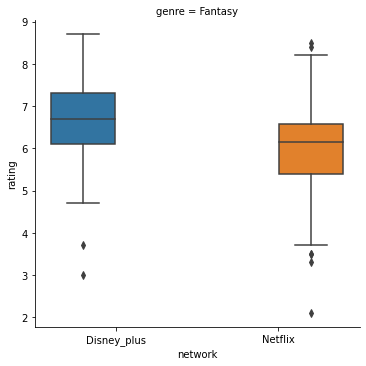

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.catplot(data = df_all_ratings[df_all_ratings["genre"]=="Fantasy"],
            hue = 'network', 
            x = 'network',
            y = 'rating',
            col = 'genre',
            kind = 'box'
           )


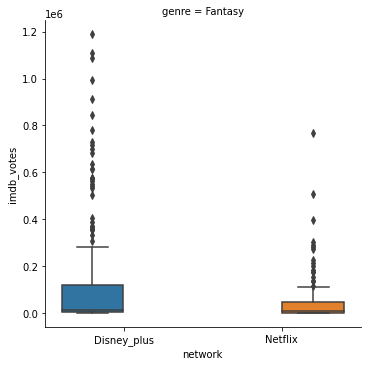

In [33]:
sns.catplot(data = df_all_ratings[df_all_ratings["genre"]=="Fantasy"],
            hue = 'network', 
            x = 'network',
            y = 'imdb_votes',
            col = 'genre',
            kind = 'box'
           )



In [28]:
ranks = df_all_ratings.groupby(['network','genre']).mean()   \
                                           .reset_index()     \
                                           .sort_values(by = ['network', 'rating'], ascending = False)

ranks[ranks["network"]=="Disney_plus"][:10]      

,network,genre,rating
10,Disney_plus,History,7.487500
15,Disney_plus,News,7.400000
16,Disney_plus,Reality-TV,7.400000
3,Disney_plus,Biography,7.293750
19,Disney_plus,Short,7.150588
6,Disney_plus,Documentary,7.012500
2,Disney_plus,Animation,6.949778
1,Disney_plus,Adventure,6.663445
0,Disney_plus,Action,6.659459
9,Disney_plus,Fantasy,6.652432


In [29]:
ranks[ranks["network"]=="Netflix"][:10]      

,network,genre,rating
43,Netflix,Short,7.300000
40,Netflix,News,7.246154
30,Netflix,Documentary,6.992778
34,Netflix,Film-Noir,6.963636
27,Netflix,Biography,6.848951
35,Netflix,History,6.783750
44,Netflix,Sport,6.747619
26,Netflix,Animation,6.694595
46,Netflix,War,6.685714
37,Netflix,Music,6.600000
